# Visualization of Daimler dataset features

In this notebook we show t-SNE visualizations of the features extracted from the Daimler datasets.
We perform the visualizations to try to answer the following questions:
 1. Are the three Daimler datasets (dealership, synthetic, used) of different domains?
 2. Is there a difference between the features extracted by DANN and by ERM?
 
The visualizations are based on a randomly selected sample of 1000 images per dataset.
 
**Summary** We extract features with a pretrained ResNet-50 feature extractor without finetuning, a ResNet-50 feature extractor finetuned with ERM and a ResNet-50 feature extractor with DANN. We reduce the dimensions of the extracted features with t-SNE and plot the result with annotations for label (car model) and dataset (dealership, synthetic or used). The visualizations show that the three datasets can be considered to be from three different domains. A difference between the types of features extracted with DANN and ERM is not clear.

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import torchvision.models
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
CLASS_NAMES = ["CLA Shooting Brake", "GLA", "GLE", "A-Class", "C-Class", "C-Class Coupé", "E-Class", "B-Class", "GLC Coupé", "GLC"]

In [3]:
all_dataset_names = ['dealership', 'synthetic', 'used']
dataset_paths = ['../data/DaimlerSample/' + dataset_name for dataset_name in all_dataset_names]

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = ConcatDataset([ImageFolder(path, transform=transform) for path in dataset_paths])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
dataloader_iterator = iter(dataloader)

In [6]:
dataset_names = []
for i, d in enumerate(dataset.datasets):
    dataset_names.extend([all_dataset_names[i]]*len(d))
df = pd.DataFrame(dataset_names, columns =['dataset'])

In [7]:
labels = []
for i, d in enumerate(dataset.datasets):
    labels.extend(d.targets)
df['label'] = labels
df['label_long'] = [CLASS_NAMES[l] for l in labels]

In [8]:
def remove_file(filename):
    try:
        os.remove(filename)
    except OSError:
        pass

## Visualizing features

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Pretrained ResNet 50 feature extractor

This feature extractor was only pretrained on ImageNet.

In [10]:
class Identity(nn.Module):
    """An identity layer"""
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


network = torchvision.models.resnet50(pretrained=True)
network.fc = Identity()

In [12]:
network.eval()
filename = "features_pretrained.pickle"
remove_file(filename)
for step in tqdm(range(len(dataloader))):
    input, target = next(dataloader_iterator)
    features = network(input)
    with open(filename, 'ab') as f:
        pickle.dump(features, f)

In [13]:
all_features = []
with open('features_pretrained.pickle', 'rb') as f:
    try:
        while True:
            all_features.append(pickle.load(f))
    except EOFError:
        pass
all_features = torch.cat(all_features)
all_features = all_features.detach().numpy()

In [14]:
tsne = TSNE()
all_features_embedded = tsne.fit_transform(all_features)
df['tsne_pretrained_0'] = all_features_embedded[:,0]
df['tsne_pretrained_1'] = all_features_embedded[:,1]

The visualization below shows the features extracted by a ResNet-50 feature extractor pretrained on ImageNet. We can see that the features extracted for each of the datasets are similar, which suggests that the three datasets are indeed from different domains. Even used car images and dealership images can be considered different domains.

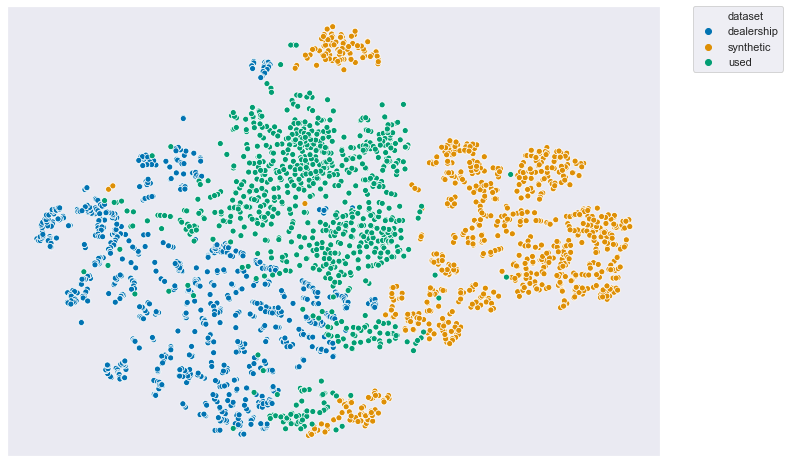

In [15]:
palette = sns.color_palette("colorblind", 3)
ax = sns.scatterplot(data=df, x='tsne_pretrained_0', y='tsne_pretrained_1', hue='dataset', legend='full', palette=palette)
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

This pretrained feature extractor was helpful to understand that there are differences between the datasets we are using, but the features extracted like this are not expected to be useful for classification yet, as the visualization below shows and is confirmed by evaluating the classification accuracy.

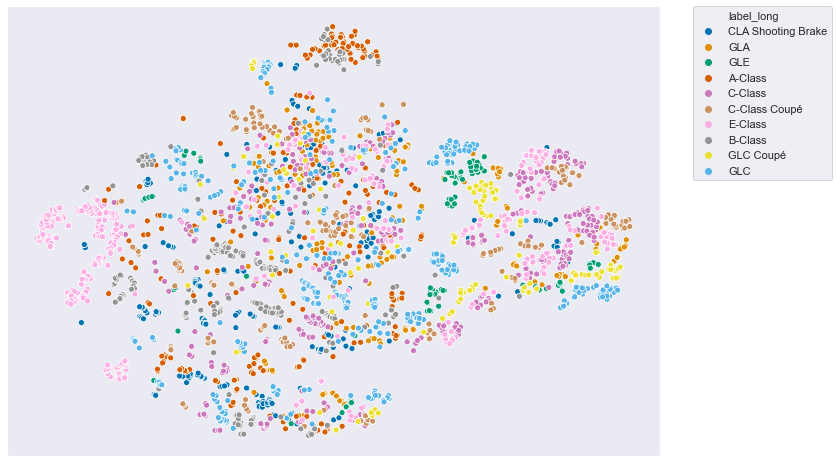

In [16]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne_pretrained_0', y='tsne_pretrained_1', hue='label_long', legend='full', palette=palette)
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Finetuned ResNet-50 feature extractor (ERM)

This feature extractor was finetuned with ERM on the sythetic and used car images.

In [17]:
load_dict = torch.load(os.path.join('../sweeps/daimler-erm/test-0/model.pkl'))
featurizer_dict = {k[19:]: v for k, v in load_dict['model_dict'].items() if k[:19] == 'featurizer.network.'}
network.load_state_dict(featurizer_dict)
dataloader_iterator = iter(dataloader)

In [18]:
network.eval()
filename = "features_erm.pickle"
remove_file(filename)
for step in tqdm(range(len(dataloader))):
    input, target = next(dataloader_iterator)
    features = network(input)
    with open(filename, 'ab') as f:
        pickle.dump(features, f)

In [19]:
all_features = []
with open('features_erm.pickle', 'rb') as f:
    try:
        while True:
            all_features.append(pickle.load(f))
    except EOFError:
        pass
all_features = torch.cat(all_features)
all_features = all_features.detach().numpy()

In [20]:
tsne = TSNE()
all_features_embedded = tsne.fit_transform(all_features)

In [21]:
df['tsne_erm_0'] = all_features_embedded[:,0]
df['tsne_erm_1'] = all_features_embedded[:,1]

#### ERM features of synthetic and used

The visualization below shows the features of the synthetic and used car images extracted after ERM training on synthetic and used car images. The feature extractor seems to be good at extracting distinctive features for the training domain samples.

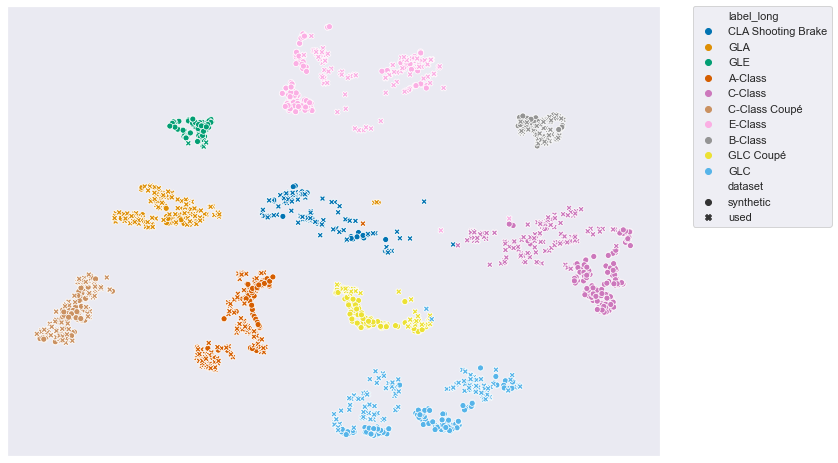

In [22]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df[df['dataset'] != 'dealership'], x='tsne_erm_0', y='tsne_erm_1', hue='label_long', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### ERM features of dealership

The features extracted for  the test domain (dealership) samples after ERM training on synthetic and used car images are (in parts) not distinct enough.

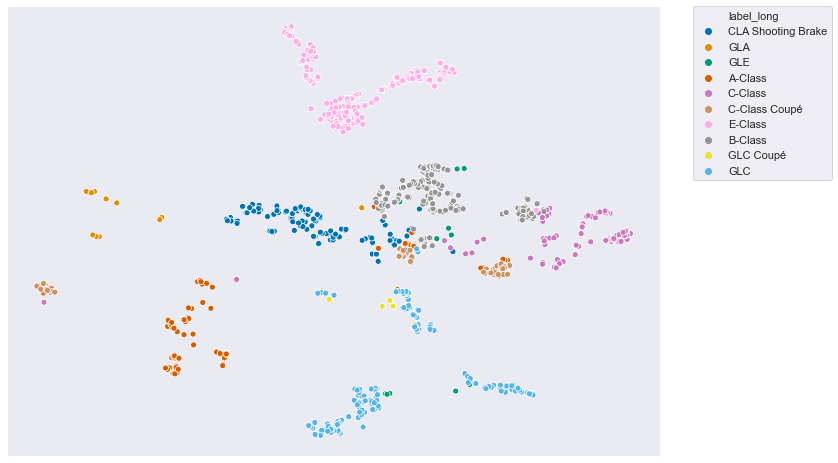

In [42]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df[df['dataset'] == 'dealership'], x='tsne_erm_0', y='tsne_erm_1', hue='label_long', legend='full', palette=palette)
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### ERM features of dealership, synthetic, used

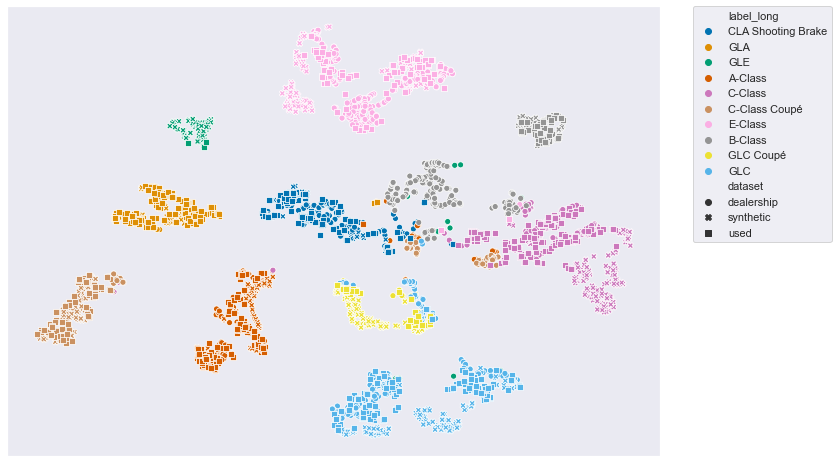

In [43]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne_erm_0', y='tsne_erm_1', hue='label_long', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Finetuned ResNet-50 feature extractor (DANN)

This feature extractor was finetuned with DANN on synthetic and used car images.

In [24]:
load_dict = torch.load(os.path.join('../sweeps/daimler-dann-lambda/test-0-train-12-lambda0.01-dsteps8/model.pkl'))
featurizer_dict = {k[19:]: v for k, v in load_dict['model_dict'].items() if k[:19] == 'featurizer.network.'}
network.load_state_dict(featurizer_dict)
dataloader_iterator = iter(dataloader)

In [25]:
network.eval()
filename = "features_dann.pickle"
remove_file(filename)
for step in tqdm(range(len(dataloader))):
    input, target = next(dataloader_iterator)
    features = network(input)
    with open(filename, 'ab') as f:
        pickle.dump(features, f)

In [26]:
all_features = []
with open('features_dann.pickle', 'rb') as f:
    try:
        while True:
            all_features.append(pickle.load(f))
    except EOFError:
        pass
all_features = torch.cat(all_features)
all_features = all_features.detach().numpy()

In [27]:
tsne = TSNE()
all_features_embedded = tsne.fit_transform(all_features)

In [28]:
df['tsne_dann_0'] = all_features_embedded[:,0]
df['tsne_dann_1'] = all_features_embedded[:,1]

#### DANN features of synthetic and used

The visualization below shows the features of the synthetic and used car images extracted after DANN training on synthetic and used car images. As with ERM training, the extracted features seem to be very useful and are able to represent the training domains well.

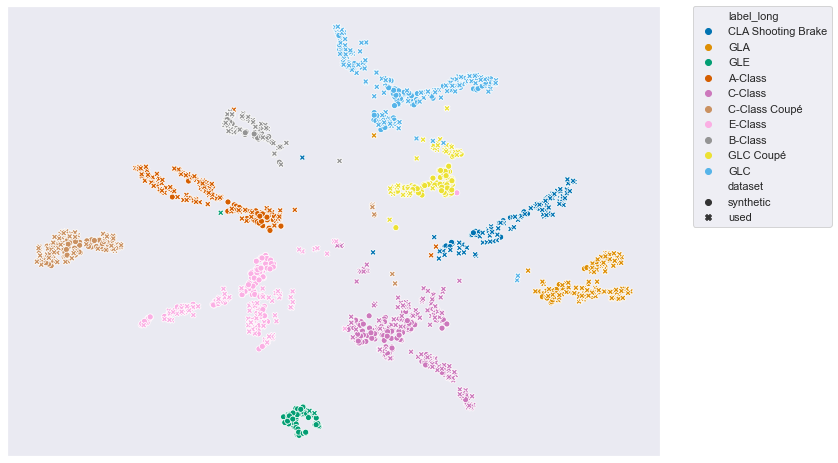

In [36]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df[df['dataset'] != 'dealership'], x='tsne_dann_0', y='tsne_dann_1', hue='label_long', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### DANN features of dealership

The features extracted for the test domain (dealership) samples after DANN training on synthetic and used car images are (in parts) not distinct enough.

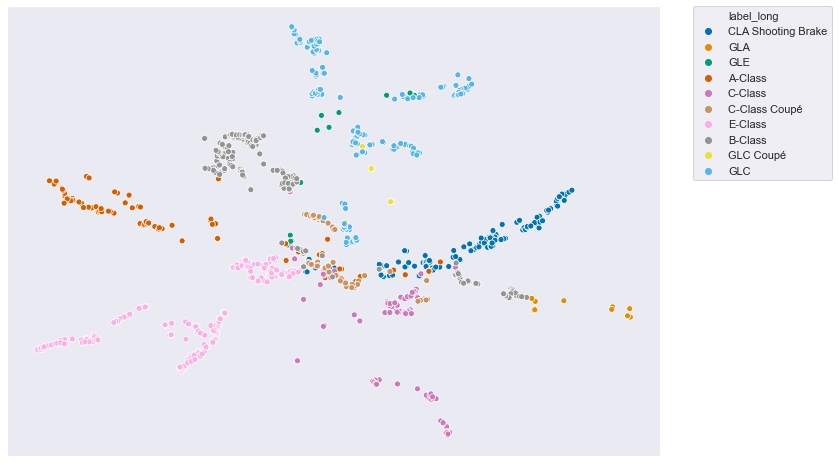

In [30]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df[df['dataset'] == 'dealership'], x='tsne_dann_0', y='tsne_dann_1', hue='label_long', legend='full', palette=palette)
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### DANN features of dealership, synthetic, used

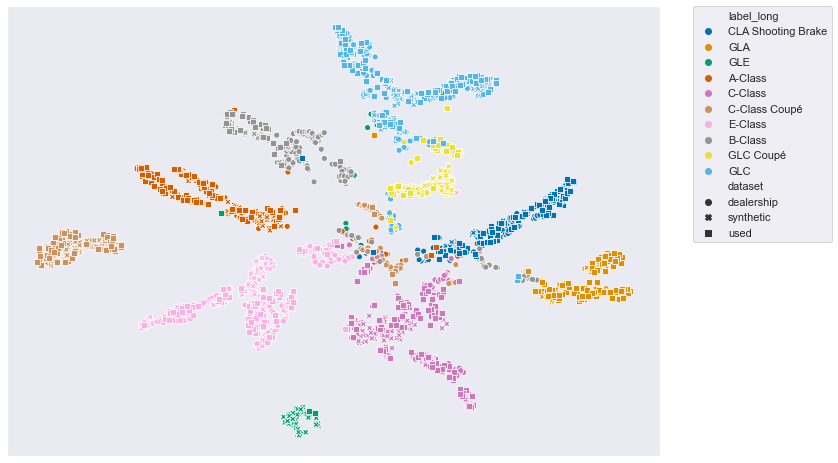

In [38]:
palette = sns.color_palette("colorblind", 10)
ax = sns.scatterplot(data=df, x='tsne_dann_0', y='tsne_dann_1', hue='label_long', legend='full', palette=palette, style='dataset')
ax.set(xlabel='', ylabel='', xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);